state를 표현하기 위해 one-hot encoding을 사용

state : np.identity(16)[s1:s1 +1] 과 같은 형태로 한 번에 생성할 수 있다.

In [43]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
from gym.envs.registration import register


In [44]:
print(np.identity(16)[0:1])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [45]:
print(np.eye(16)[10:11])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [46]:
print(np.identity(16))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [47]:
def one_hot(x):
    return np.identity(16)[x:x+1]

In [62]:
env = gym.make('FrozenLake-v0')

In [63]:
# Input and output siza based on the Env
input_size = env.observation_space.n # 4
output_size = env.action_space.n # 4
learning_rate = 0.1

In [64]:
# These lines establish the feed-forward part of the network used to choose actions
X = tf.placeholder(shape=[1, input_size], dtype=tf.float32) # state input
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01)) # weight

Qpred = tf.matmul(X, W) # out Q prediction
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32) # Y label

loss = tf.reduce_sum(tf.square(Y-Qpred))

train = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

In [65]:
# Set Q-learning related parameters
dis = 0.99
num_episodes = 2000

In [66]:
# create lists to contain total rewards and steps per episode
rList = []

In [67]:
init = tf.global_variables_initializer()

In [70]:
with tf.Session() as sess:
    sess.run(init) # init = tf.global_variables_initializer() 
    for i in range(num_episodes):
        # Reset environment and get first new observation
        s = env.reset()
        e = 1.0 / ( (i / 50) + 10 )
        rAll = 0
        done = False
        local_loss = []
        
        # The Q-Network training
        while not done:
            # Choose an action by greedily (with e chance of ramdom action) from the Q-network
            Qs = sess.run(Qpred, feed_dict={X: one_hot(s)}) # just table -> network
            if np.random.rand(1) < e :
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)

            # Get new state and reward from environment
            s1, reward, done, _ = env.step(a)
            # Terminal or not
            if done:
                # Update Q, and no Qs+1, since it's a terminal state
                Qs[0, a] = reward
            else:
                # Obtain the Q_s1 values by feeding the new state through our network
                Qs1 = sess.run(Qpred, feed_dict={X: one_hot(s1)})
                # Update Q
                Qs[0, a] = reward + dis * np.max(Qs1)

            # Train out network using target (Y) and predicted Q (Qpred) values
            sess.run(train, feed_dict = {X: one_hot(s), Y: Qs})

            rAll += reward
            s = s1
        rList.append(rAll)
            


Percent of successful episodes: 0.4535%


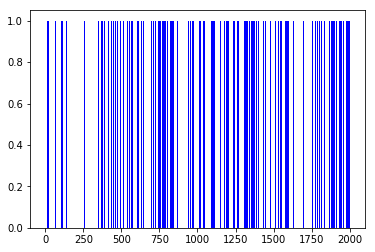

In [71]:
print("Percent of successful episodes: " + str(sum(rList)/num_episodes) + "%")
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

# Exercise

* Too slow
    - Minibatch?


* A bit unstable?